# Process tomography
Quantum process tomography involves
 - preparing a state
 - executing a process
 - measuring in a basis
 
The process is kept fixed, while the experimental settings ((prep, measure) tuples) are varied. You first choose a suitable set of input states and measurement operators, and then run every `itertools.product` combinations of settings.

For input states, we choose the SIC basis comprised of four states, and wee measure in the Pauli basis. The scalling w.r.t. number of qubits is therefore $4^n 3^n$, which is very exponential. If you use the $\pm$ eigenstates of the pauli operators, it scales as $6^n 3^n$.

In [ ]:
import numpy as np
from pyquil import Program, get_qc
from pyquil.gates import *

## Construct a process
Which is represented as a pyQuil `Program`

In [ ]:
qubits = [0]
process = Program(RX(np.pi, qubits[0]))
print(process)

## Construct a `TomographyExperiment` for process tomography
The `I` basis measurements are redundant, and can be grouped with other terms (see below).

In [ ]:
from forest.benchmarking.tomography import generate_process_tomography_experiment
experiment = generate_process_tomography_experiment(process, qubits)
print(experiment)

## PyQuil will run the tomography programs

In [ ]:
from pyquil.operator_estimation import measure_observables

qc = get_qc('2q-pyqvm')
# Over-write full quilc compilation with a much more simple
# version that *only* substitutes gates to Rigetti-native gates.
# We don't want to accidentally compile away our tomography circuit
# or map to different qubits.
from forest_benchmarking.compilation import basic_compile
qc.compiler.quil_to_native_quil = basic_compile

results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=100_000))
results

## PGDB Estimate

In [ ]:
from forest.benchmarking.tomography import pgdb_process_estimate
process_choi_est = pgdb_process_estimate(results, qubits)
np.real_if_close(np.round(process_choi_est, 2))

In [ ]:
from forest.benchmarking.superoperator_tools import kraus2choi
from pyquil.gate_matrices import X as X_matrix
process_choi_ideal = kraus2choi(X_matrix)
np.real_if_close(np.round(process_choi_ideal))

## Plot Pauli Transfer Matrix of Estimate

NameError: name 'process_choi_ideal' is not defined

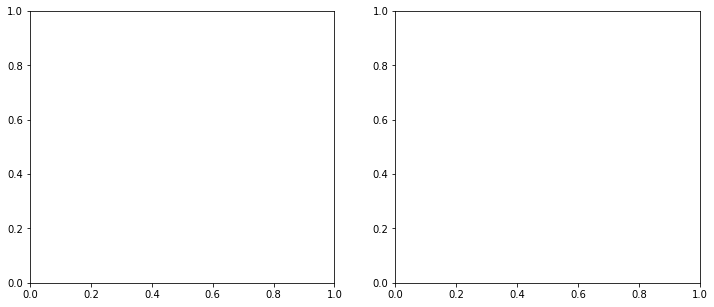

In [7]:
import matplotlib.pyplot as plt
from forest.benchmarking.superoperator_tools import choi2pauli_liouville
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_ideal), ax1, title='Ideal')
plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_est), ax2, title='Estimate')
plt.tight_layout()

## Two qubit example - CNOT

In [ ]:
qubits = [0, 1]
process = Program(CNOT(qubits[0], qubits[1]))
experiment = generate_process_tomography_experiment(process, qubits)
print(experiment)

In [ ]:
results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=100_000))
results[:10]

In [ ]:
def _print_big_matrix(mat):
    for row in mat:
        for elem in row:
            elem = np.real_if_close(np.round(elem, 2))
            if elem != 0:
                print(f'{elem:.1f}', end=' ')
            else:
                print(' . ', end=' ')
        print()

In [ ]:
process_choi_est = pgdb_process_estimate(results, qubits)
_print_big_matrix(process_choi_est)

In [ ]:
from pyquil.gate_matrices import CNOT as CNOT_matrix
process_choi_ideal = kraus2choi(CNOT_matrix)
_print_big_matrix(process_choi_ideal)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_ideal), ax1, title='Ideal')
plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_est), ax2, title='Estimate')
plt.tight_layout()